# Diffusion Models for CMB signal sampling

We explore applications of Denoising Diffusion Models to separate the true CMB signal from lensing and foreground noise ( dust and synchroton emission ). 

#### Separating foreground signal (dust and synchroton) from CMB data. 

Component separation methods can be broadly categorized into two
types: blind methods and non-blind methods. Nonblind methods typically rely on prior knowledge of the
emission characteristics of foregrounds. When faced with unknown or complex foregrounds, such approaches may introduce biases in the
detection of CMB B-modes (Armitage-Caplan et al.
2012; Remazeilles et al. 2016; Hensley & Bull 2018). In
contrast, blind source component separation algorithms
do not rely on prior knowledge of foregrounds. Instead,
they leverage the independent statistical properties of
different components to separate signals.

We are interested on training a DM starting from simulated foreground emission data, focusing on dust and synchroton emission in particular. The are two main simulators people use: 1) PySM 3 is explicitly built for full-sky I/Q/U foreground simulations for CMB experiments (bandpasses, beams, HEALPix, Monte Carlos). 2) Hammurabi is a physics-driven synchrotron sky (3D Galaxy → Q/U via line-of-sight integrals through Galactic magnetic field + cosmic-ray electrons, with turbulence models).

In [3]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pysm3
import pysm3.units as u
import healpy as hp

import warnings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Sampling foreground

Our goal is to sample the posterior distribution of the foreground conditioned on the onserved CMB data $p(\epsilon | d)$, where $\epsilon = $ foreground signal and $d = $ observed CMB data. 

Since we are conditioning on foreground we will use PySM 3 to simulate foreground data for training.

#### PySM 3

In [ ]:
"""
Sky is the main class in PySM 3. It contains the information about the sky model, including the components, the parameters, and the units.
nside (int): The HEALPix resolution parameter.
"""
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"]) 
sky.components

In [ ]:
"""
get_emission(frequency, **kwargs): Get the emission at a given frequency.
Returns 2D array of shape (3, nside, nside) in healpy convention.

map_100GHz.shape = (3, 12*128*128)
The number 12 is the foundation of the HEALPix geometry. 
At the lowest possible resolution (NSIDE = 1), the sphere is divided into 12 base pixels.
Each base pixel is then subdivided into 4 child pixels at the next resolution level (NSIDE = 2), and so on.
"""

map_100GHz = sky.get_emission(100 * u.GHz)
map_100GHz[:,0] # returns [I, Q, U] for first base pixel





<Quantity [ 1.86866125,  0.01538318, -0.09826734] uK_RJ>

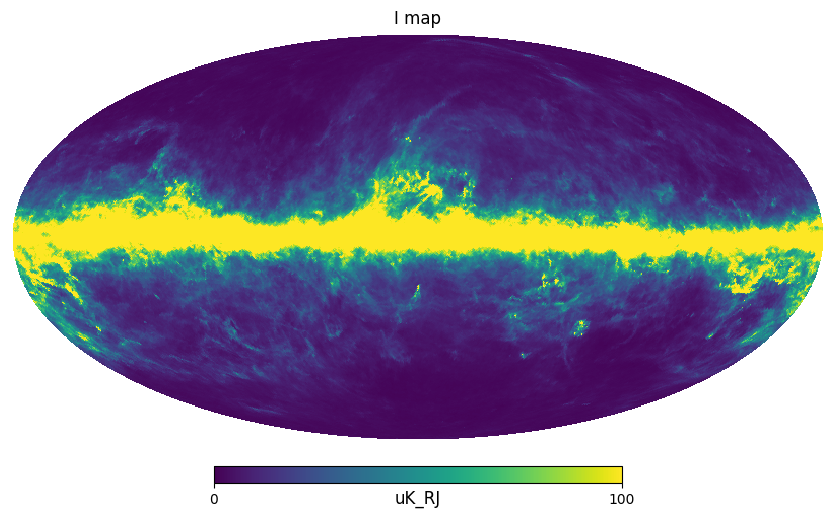

In [23]:
hp.mollview(map_100GHz[0], min=0, max=1e2, title="I map", unit=map_100GHz.unit)


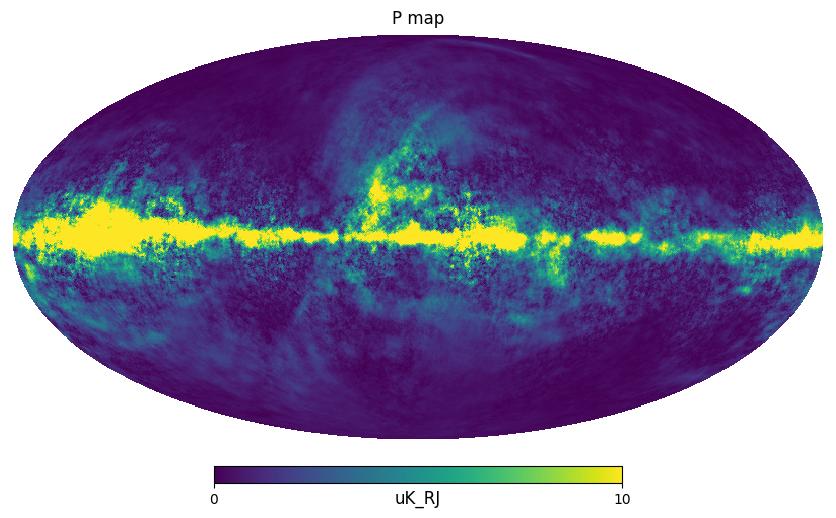

In [24]:
hp.mollview(np.sqrt(map_100GHz[1]**2 + map_100GHz[2]**2), title="P map", min=0, max=1e1, unit=map_100GHz.unit)
